# Modelos probabilísticos (Ejercicio)

## Aplicación de Naive Bayes multinomial a la detección de SMS *spam*

En este ejercicio se pide reproducir lo realizado en el caso práctico que se ha descrito en los vídeos (análisis de sentimiento en críticas de cine), pero ahora para detectar cuándo un mensaje corto (SMS) es *spam*.

### El conjunto de datos

El conjunto de datos consiste una serie de mensajes SMS (5574 en total), que están clasificados como mensajes basura (*spam*) o mensajes normales (*ham*). Los datos se pueden obtener en el [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

En concreto, descargar el fichero [smsspamcollection.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip), y descomprimirlo para obtener un fichero de texto SMSSpamCollection. En este fichero de texto hay una línea por cada sms, con el formato: *clase* *tabulador* *sms*. Por ejemplo, la primera línea es:

`ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...`

El fichero debe ser leído convenientemente para poder aplicar la vectorización. Se puede hacer la lectura usando las funciones python de lectura de ficheros, pero se recomienda usar la instrucción `read_table` de la biblioteca `pandas`:

In [1]:
import pandas as pd

*Pandas* es una biblioteca de python muy utilizada para manipular y analizar datos. Si el fichero se lee con la orden `read_table` (se pide averiguar la manera concreta de hacerlo), entonces se obtendrá una tabla (o *Data Frame*), en el que las etiquetas serán una columna y los correspondientes sms otra. Esto permite obtener de manera sencilla la lista de etiquetas o clases, y por otro lado la lista de mensajes, en el mismo orden.  

### Aprendiendo a clasificar SMSs

Se pide reproducir con estos datos lo realizado en el *notebook* en el que se aplica Naive Bayes Multinomial al análisis de sentimientos de críticas de cine, pero ahora para clasificar un SMS como *spam* o como normal. Esto incluye:

* Separación de los textos en entrenamiento y prueba 
* Vectorización de los textos 
* Aprendizaje con `MultinomialNB`
* Mostrar algunas clasificaciones sobre sms concretos.
* Rendimiento sobre entrenamiento y prueba.
* Ajuste manual del parámetro de suavizado
* Vectorización con `min_df` y `stop_words` 

**Nota**: este conjunto de datos no es balanceado (la mayoría son *ham*). Por tanto, usar `score` no es muy ilustrativo del rendimiento, ya que un clasificador "tonto" que siempre predijera *ham* tendría un rendimiento alto. Por ello, en este caso también se hace necesario usar el método `confusion_matrix` del módulo `metrics`. Se pide también explicar la salida que proporciona dicha métrica.

Se pide **comentar adecuadamente cada paso realizado**, relacionándolo con lo visto en la teoría. En particular, se pide mostrar parte de los atributos `class_count_`, `class_log_prior_`, `feature_count_` y `feature_log_prob_`, explicando claramente qué son cada uno de ellos. Explicar también cómo realiza las predicciones el modelo aprendido, tal y como se ha explicado en la teoría.  



# Solución

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
df = pd.read_table('./smsspamcollection/SMSSpamCollection', header=None, sep='\t', names = ['target','sms'])
df.target = pd.Categorical(df.target)
df['target'] = df.target.cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   int8  
 1   sms     5572 non-null   object
dtypes: int8(1), object(1)
memory usage: 49.1+ KB


In [4]:
print("Nulos encontrados: %i " %df.isnull().values.sum())

Nulos encontrados: 0 


In [5]:
df.head()

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.tail()

,target,sms
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...
5571,0,Rofl. Its true to its name


In [7]:
print("Instancias de tipo normal: ", df[df['target'] == 0].count()) # ham
print("Instancias de tipo SPAM: ", df[df['target'] == 1].count()) # spam 

Instancias de tipo normal:  target    4825
sms       4825
dtype: int64
Instancias de tipo SPAM:  target    747
sms       747
dtype: int64


In [8]:
sms = df.sms.tolist()
target = df.target.tolist()

text_train, text_test, y_train, y_test = train_test_split(sms, target, stratify = target, test_size = 0.3)

print("Ejemplos por cada clase en conjunto de entrenamiento: {}".format(np.bincount(y_train)))
print("Ejemplos por cada clase en conjunto de prueba: {}".format(np.bincount(y_test)))

Ejemplos por cada clase en conjunto de entrenamiento: [3377  523]
Ejemplos por cada clase en conjunto de prueba: [1448  224]


In [9]:
vect = CountVectorizer().fit(text_train)

In [10]:
print("Tamaño del vocabulario: {}".format(len(vect.vocabulary_)))

Tamaño del vocabulario: 7259


In [11]:
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<3900x7259 sparse matrix of type '<class 'numpy.int64'>'
	with 52057 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Número de términos en el vocabulario: {}".format(len(feature_names)))
print("Primeras 20 características (términos):\n{}".format(feature_names[:20]))
print("Términos del 1010 al 1030:\n{}".format(feature_names[1010:1030]))
print("Términos cada 200 posiciones:\n{}".format(feature_names[::200]))

Número de términos en el vocabulario: 7259
Primeras 20 características (términos):
['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '021', '03', '04', '0430', '05', '050703', '0578']
Términos del 1010 al 1030:
['arise', 'arithmetic', 'arm', 'armand', 'armenia', 'arms', 'arng', 'around', 'aroundn', 'arr', 'arrange', 'arranging', 'arrested', 'arrival', 'arrive', 'arrived', 'arsenal', 'art', 'artists', 'arts']
Términos cada 200 posiciones:
['00', '09064015307', '2yrs', '800', 'advisors', 'arent', 'bcmsfwc1n3xx', 'brains', 'cc', 'common', 'customersqueries', 'dirty', 'elama', 'familiar', 'free', 'goods', 'hero', 'immediately', 'joker', 'lead', 'lvblefrnd', 'mileage', 'nannys', 'often', 'pause', 'positive', 'quiz', 'restaurant', 'sculpture', 'singapore', 'spl', 'sunshine', 'themob', 'trek', 'vegas', 'whats', 'yeovil']


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# Regresión logística con el parámetro por defecto: alpha = 1.0
multinb=MultinomialNB().fit(X_train,y_train)

In [14]:
print(multinb.class_count_)
print(multinb.class_log_prior_)
print(multinb.feature_count_)
print(multinb.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  1. ...  1.  0.  1.]
 [ 7. 22.  0. ...  0.  1.  0.]]
[[-10.84844348 -10.84844348 -10.1552963  ... -10.1552963  -10.84844348
  -10.1552963 ]
 [ -7.79975332  -6.74370064  -9.87919486 ...  -9.87919486  -9.18604768
   -9.87919486]]


In [15]:
print("Segunda crítica del conjunto de test: \n\n{}\n".format(text_test[1]))
print("Clasificación verdadera: {}.\n\n".format(y_test[1]))

print("Sexta crítica del conjunto de test: \n\n{}\n".format(text_test[2]))
print("Clasificación verdadera: {}".format(y_test[5]))

Segunda crítica del conjunto de test: 

Babes I think I got ur brolly I left it in English wil bring it in 2mrw 4 u luv Franxx

Clasificación verdadera: 0.


Sexta crítica del conjunto de test: 

Watching cartoon, listening music &amp; at eve had to go temple &amp; church.. What about u?

Clasificación verdadera: 0


In [16]:
print("Predicción del clasificador para la segunda crítica: {}\n".format(multinb.predict(vect.transform([text_test[1]]))[0]))

print("Predicción del clasificador para la sexta crítica: {}".format(multinb.predict(vect.transform([text_test[5]]))[0]))

Predicción del clasificador para la segunda crítica: 0

Predicción del clasificador para la sexta crítica: 0


In [17]:
print("Predicción de probabilidad para la segunda crítica: {}\n".format(multinb.predict_proba(vect.transform([text_test[1]]))[0]))

print("Predicción de probabilidad para la sexta crítica: {}".format(multinb.predict_proba(vect.transform([text_test[5]]))[0]))

Predicción de probabilidad para la segunda crítica: [9.99999992e-01 8.43848989e-09]

Predicción de probabilidad para la sexta crítica: [9.99996081e-01 3.91873617e-06]


In [18]:
X_test = vect.transform(text_test)
print("Rendimiento de multinb sobre el conjunto de entrenamiento: {:.2f}".format(multinb.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento: 0.99
Rendimiento de multinb sobre el conjunto de test: 0.98


In [19]:
# TODO: confusion_matrix
# https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d
# Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = multinb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

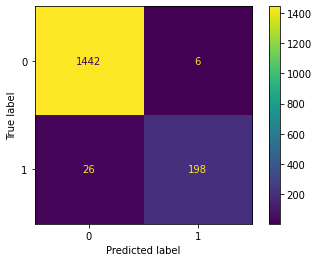

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [21]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 1.00
Score para los mensajes SPAM: 0.88


In [22]:
multinb_alpha=MultinomialNB(alpha=10).fit(X_train,y_train)
print("Rendimiento de multinb sobre el conjunto de entrenamiento {:.2f}".format(multinb_alpha.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb_alpha.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento 0.96
Rendimiento de multinb sobre el conjunto de test: 0.95


In [23]:
print(multinb_alpha.class_count_)
print(multinb_alpha.class_log_prior_)
print(multinb_alpha.feature_count_)
print(multinb_alpha.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  1. ...  1.  0.  1.]
 [ 7. 22.  0. ...  0.  1.  0.]]
[[-9.36550482 -9.36550482 -9.27019464 ... -9.27019464 -9.36550482
  -9.27019464]
 [-8.51543871 -7.88291615 -9.04606696 ... -9.04606696 -8.95075678
  -9.04606696]]


In [24]:
param_grid_nb = {'alpha': [0.0001,0.001, 0.01,0.1, 1, 10,100,200]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train, y_train)
print("Mejor parámetro: ", grid_nb.best_params_)
print("Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: {:.2f}".format(grid_nb.best_score_))

Mejor parámetro:  {'alpha': 1}
Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: 0.98


In [25]:
# TODO: confusion_matrix
# https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d
y_pred = multinb_alpha.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

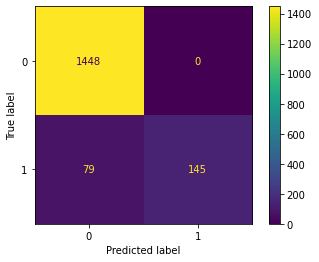

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [27]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 1.00
Score para los mensajes SPAM: 0.65


In [28]:
vect2 = CountVectorizer(min_df=3, stop_words='english').fit(text_train)
X2_train = vect2.transform(text_train)

In [29]:
print("Número de términos en el vocabulario original: {}".format(len(vect.get_feature_names_out())))
feature_names2 = vect2.get_feature_names_out()
print("Número de términos en el vocabulario con stop words y min_df: {}".format(len(feature_names2)))

Número de términos en el vocabulario original: 7259
Número de términos en el vocabulario con stop words y min_df: 1996


In [30]:
multinb2=MultinomialNB(alpha=0.1).fit(X2_train,y_train)

In [31]:
print(multinb2.class_count_)
print(multinb2.class_log_prior_)
print(multinb2.feature_count_)
print(multinb2.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  0. ...  5. 30.  0.]
 [ 7. 22.  7. ...  0.  0.  3.]]
[[-12.17821829 -12.17821829 -12.17821829 ...  -8.24639266  -6.47110803
  -12.17821829]
 [ -6.87796377  -5.74248095  -6.87796377 ... -11.14064365 -11.14064365
   -7.70665645]]


In [32]:
X2_test = vect2.transform(text_test)

print("Rendimiento de multinb2 sobre el conjunto de entrenamiento {:.2f}".format(multinb2.score(X2_train,y_train)))
print("Rendimiento de multinb2 sobre el conjunto de test: {:.2f}".format(multinb2.score(X2_test,y_test)))

Rendimiento de multinb2 sobre el conjunto de entrenamiento 0.99
Rendimiento de multinb2 sobre el conjunto de test: 0.98


In [33]:
grid2_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid2_nb.fit(X2_train, y_train)
print("Mejor parámetro: ", grid2_nb.best_params_)
print("Rendimiento de MultonomialNB (con min_df y stop words) en validación cruzada, con el mejor parámetro: {:.2f}".format(grid2_nb.best_score_))
print("Rendimiento sobre prueba (del mejor parámetro en validación cruzada): {:.2f}".format(grid2_nb.score(X2_test, y_test)))

Mejor parámetro:  {'alpha': 10}
Rendimiento de MultonomialNB (con min_df y stop words) en validación cruzada, con el mejor parámetro: 0.98
Rendimiento sobre prueba (del mejor parámetro en validación cruzada): 0.98


In [34]:
# TODO: confusion_matrix
# https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d
y_pred = multinb2.predict(X2_test)
cm = confusion_matrix(y_test, y_pred)
cm # print

array([[1434,   14],
       [  21,  203]])

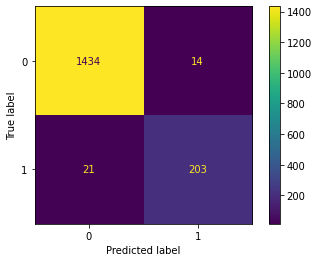

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [36]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 0.99
Score para los mensajes SPAM: 0.91
